In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/cv_project_fall_2022')

In [4]:
import os
import torch
from torch.utils.data import DataLoader

import utils.utils as utils
from models.definitions.transformer_net_new import TransformerNet

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [5]:
def stylize_static_image(inference_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare the model - load the weights and put the model into evaluation mode
    stylization_model = TransformerNet().to(device)
    model_saved_path = inference_config['model_saved_path']
    training_state = torch.load(model_saved_path)
    state_dict = training_state["state_dict"]
    stylization_model.load_state_dict(state_dict, strict=True)
    stylization_model.eval()

    if inference_config['verbose']:
        utils.print_model_metadata(training_state)

    content_img_path = inference_config['content_images_path']
    print(content_img_path)
    content_image_to_show = Image.open(content_img_path)
    plt.imshow(content_image_to_show)
    plt.show()

    style_image_path = inference_config['style_images_path']
    style_image_to_show = Image.open(style_image_path)
    plt.imshow(style_image_to_show)
    plt.show()

    with torch.no_grad():
        transform_list = [transforms.ToTensor()]
        transform = transforms.Compose(transform_list)
        
        target_transform_list = [transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(51, 51), sigma=(70, 70))]
        transform_target = transforms.Compose(target_transform_list)
        
        img = utils.load_image(content_img_path, target_shape=inference_config['img_width'])
        img = transform(img).to(device)

        face_masked_image_batch = utils.load_image(inference_config['content_images_mask_path'], target_shape=inference_config['img_width'], RGB=False)
        face_masked_image_batch = transform_target(face_masked_image_batch).to(device)
        face_masked_image_batch = face_masked_image_batch * 0.03

        result = torch.cat([img, face_masked_image_batch], dim=0)

        print(' Infering...')
        print(img.shape)
        content_image = result.repeat(1, 1, 1, 1)
        print(content_image.shape)
        print(' Infering Ends...')
        stylized_img = stylization_model(content_image).to('cpu').numpy()[0]
        utils.save_and_maybe_display_image(inference_config, stylized_img, should_display=inference_config['should_not_display'])


In [6]:
content_images_path = os.path.join('/content/drive/MyDrive/cv_project_fall_2022', 'data', 'content-images')
output_images_path = os.path.join('/content/drive/MyDrive/cv_project_fall_2022', 'data', 'output-images')
model_binaries_path = os.path.join('/content/drive/MyDrive/cv_project_fall_2022', 'models', 'binaries')
os.makedirs(output_images_path, exist_ok=True)

In [12]:

#assert utils.dir_contains_only_models(model_binaries_path), f'Model directory should contain only model binaries.'


#
# Modifiable args - feel free to play with these
#
# parser = argparse.ArgumentParser()
# # Put image name or directory containing images (if you'd like to do a batch stylization on all those images)
# parser.add_argument("--content_input", type=str, help="Content image(s) to stylize", default='taj_mahal.jpg')
# parser.add_argument("--batch_size", type=int, help="Batch size used only if you set content_input to a directory", default=5)
# parser.add_argument("--img_width", type=int, help="Resize content image to this width", default=500)
# parser.add_argument("--model_name", type=str, help="Model binary to use for stylization", default='mosaic_4e5_e2.pth')

# # Less frequently used arguments
# parser.add_argument("--should_not_display", action='store_false', help="Should display the stylized result")
# parser.add_argument("--verbose", action='store_true', help="Print model metadata (how the model was trained) and where the resulting stylized image was saved")
# parser.add_argument("--redirected_output", type=str, help="Overwrite default output dir. Useful when this project is used as a submodule", default=None)
# args = parser.parse_args()

# # if redirected output is not set when doing batch stylization set to default image output location
# if os.path.isdir(args.content_input) and args.redirected_output is None:
#     args.redirected_output = output_images_path

# Wrapping inference configuration into a dictionary


inference_config = dict()

# Content image(s) to stylize
inference_config['content_input'] = 'lion.jpg'
# Resize content image to this width
inference_config['img_width'] = 500

inference_config['style_images_path'] = '/content/drive/MyDrive/cv_project_fall_2022/data/style-images/mosaic.jpg'

model_binaries_path = model_binaries_path + "/mosaic_4e5_e2.pth"

# 1st conv layer
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_content_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_9_batch_1899.pth'
# 3rd conv layer
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_content_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'
# 1st conv layer
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_1st_layer_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'

# 2nd conv layer
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_1st_layer_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'

# 2nd conv layer - using content and style loss of layer 2
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/ckpt_style_face_layer_2_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'

inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/ckpt_style_depth_face_edge_layer_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_0_batch_1399.pth'

# Depth and Face Edge - Final
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/ckpt_style_depth_face_edge_layer_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'

# Face Edge Only Mosaic
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/ckpt_style_face_edge_only_new_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_6_batch_1899.pth'

# Face Edge Only - Final
#inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/ckpt_style_face_edge_only_ldc_pre_mask_new_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_9_batch_1899.pth'

# Test 
#inference_config['model_saved_path'] = model_binaries_path
inference_config['model_saved_path'] = "/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/blurred_ckpt_style_face_layer_1_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_0_batch_1699.pth"
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/blurred_ckpt_style_face_layer_1_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_499.pth'
#inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/ckpt_style_face_layer_2_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'

#inference_config['model_saved_path'] = "/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_3rd_layer_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth"


#inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/edtaonisl/ckpt_style_face_edtaonisl_cw_1.0_sw_400000.0_tw_0_epoch_3_batch_1899.pth'



'''Mosaic'''
# [TODO] Edge Loss
# [WIP]  Content Preserve + Content Style Transfer on Face
inference_config['model_saved_path'] = '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints/mosaic/blurred_ckpt_style_face_layer_1_mosaic_cw_1.0_sw_400000.0_tw_0_epoch_4_batch_1499.pth'


# [TODO] Style Transfer on Face using blurred Style Image 

'''Edtaonist'''
# [TODO] Edge Loss
# [TODO] Content Preserve + Content Style Transfer on Face
# [TODO] Style Transfer on Face using blurred Style Image 

'''Starry Night'''
# [TODO] Edge Loss
# [TODO] Content Preserve + Content Style Transfer on Face
# [TODO] Style Transfer on Face using blurred Style Image 


inference_config['should_not_display'] = True
inference_config['verbose'] = True

inference_config['output_images_path'] = output_images_path
inference_config['model_binaries_path'] = model_binaries_path
inference_config['redirected_output'] = output_images_path


test_images_path = '/content/drive/MyDrive/cv_project_fall_2022/face_mask/test_images/'
all_test_images = os.listdir(test_images_path)


def get_mask_path(file_path):
    file_name = file_path.split('/')[-1]
    file_name_split = file_name.split('_')
    if(file_name_split[1] == 'Election'):
        file_name_split[1] = 'Election_Campain'
    if(file_name_split[1] == 'Press'):
        file_name_split[1] = 'Press_Conference'
    
    

    dir_name = file_name_split[0] + '--' + file_name_split[1]
    return file_path.replace("/test_images/", "/data/widerface/WIDER_train/masks/" + dir_name + "/")

for test_image in all_test_images:
    inference_config['content_images_path'] = test_images_path + test_image
    inference_config['content_images_mask_path'] = get_mask_path(inference_config['content_images_path'])
    stylize_static_image(inference_config)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# import face_mask

In [ ]:
# https://github.com/onnx/models#body_analysis

In [ ]:
# https://www.analyticsvidhya.com/blog/2018/07/top-10-pretrained-models-get-started-deep-learning-part-1-computer-vision/

In [ ]:
# https://modelzoo.co/

In [ ]:
# https://github.com/topics/face-segmentation

In [ ]:
file_path = '/content/drive/MyDrive/cv_project_fall_2022/face_mask/test_images/0_Parade_Parade_0_467.jpg'
file_name = file_path.split('/')[-1]
file_name_split = file_name.split('_')
dir_name = file_name_split[0] + '--' + file_name_split[1]
file_path.replace("/test_images/", "/data/widerface/WIDER_train/masks/" + dir_name + "/" + file_name)

'/content/drive/MyDrive/cv_project_fall_2022/face_mask/data/widerface/WIDER_train/masks/0--Parade/0_Parade_Parade_0_467.jpg0_Parade_Parade_0_467.jpg'

In [ ]:
4e5

400000.0

In [ ]:
1e-2

0.01

<class 'numpy.ndarray'>


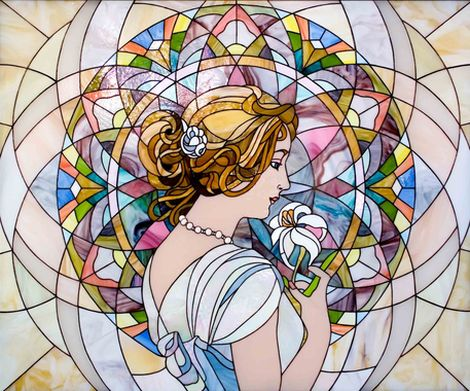

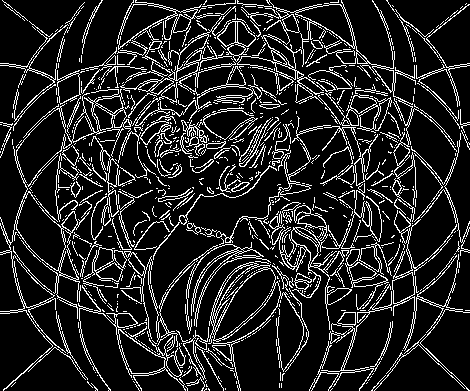

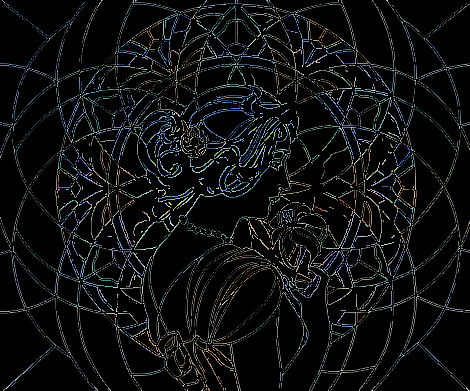

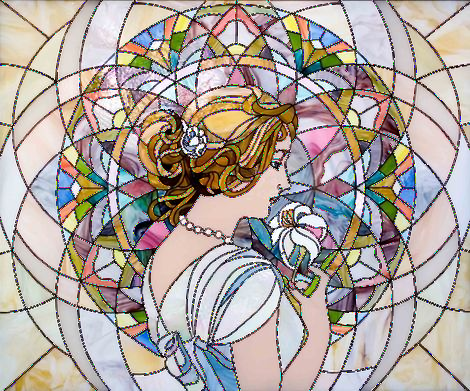

In [ ]:
## Test style image

test_style_images_path = '/content/drive/MyDrive/cv_project_fall_2022/data/style-images/mosaic.jpg'

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(test_style_images_path)  # Read image
#img = cv2.resize(img,(256,256))
print(type(img))
cv2_imshow(img)
  
# # Setting parameter values
t_lower = 500  # Lower Threshold
t_upper = 600  # Upper threshold
  
# Applying the Canny Edge filter
edge = cv2.Canny(img, t_lower, t_upper) 
cv2_imshow(edge)

img_transposed = img.transpose((2,0,1))

img_masked = img_transposed * edge
cv2_imshow(img_masked.transpose((1,2,0)))

new_img = img_transposed - img_masked

cv2_imshow(new_img.transpose((1,2,0)))

In [ ]:
new_img.transpose((1,2,0)).shape

(391, 470, 3)

In [ ]:
img.shape

(391, 470, 3)

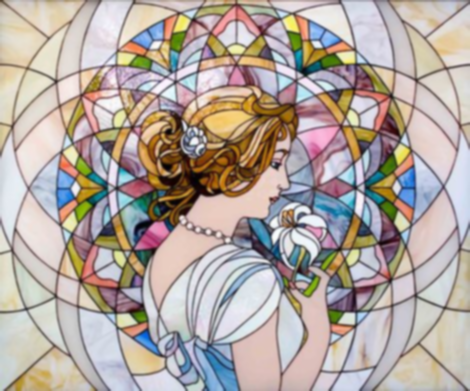

In [ ]:
blur = cv2.GaussianBlur(img,(5,5),0)
cv2_imshow(blur)

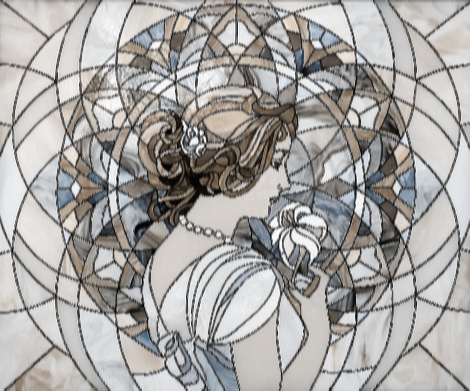

In [ ]:
blur = cv2.GaussianBlur(new_img,(5,5),0)
cv2_imshow(blur.transpose((1,2,0)))

In [ ]:
image = cv2.imread(test_style_images_path)
result = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


In [ ]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 5)

In [ ]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 5)

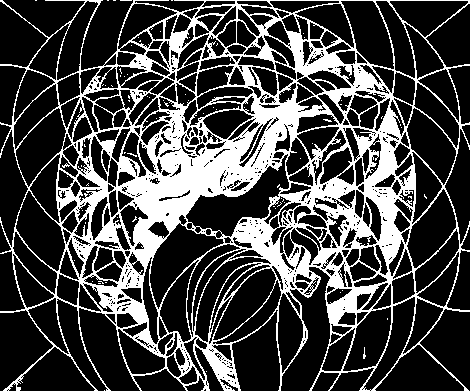

(391, 470)

In [ ]:
import cv2

image = cv2.imread(test_style_images_path)
result = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, 9)[1]

# # Remove horizontal lines
# horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
# remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
# cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(result, [c], -1, (255,255,255), 5)

# # Remove vertical lines
# vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
# remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
# cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(result, [c], -1, (255,255,255), 5)

cv2_imshow(thresh)
#cv2_imshow(result)
#cv2.imwrite('result.png', result)
#cv2.waitKey()
#cv2.THRESH_BINARY_INV #+ cv2.THRESH_OTSU
cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU

thresh.shape

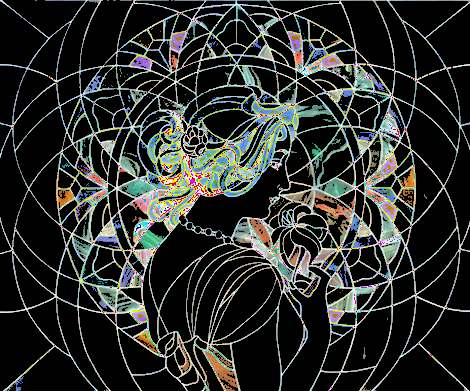

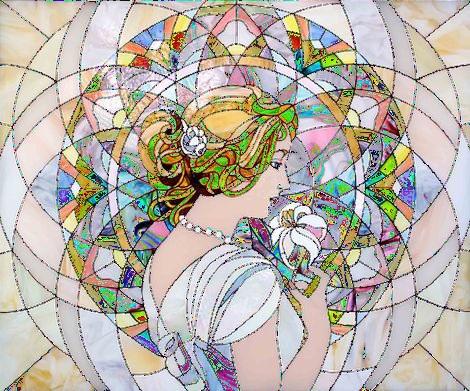

In [ ]:

img_masked = img_transposed * thresh
cv2_imshow(img_masked.transpose((1,2,0)))

new_img = img_transposed - img_masked

cv2_imshow(new_img.transpose((1,2,0)))

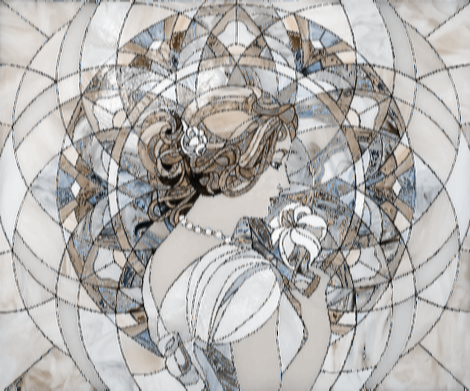

In [ ]:
blur = cv2.GaussianBlur(new_img,(5,5),0)
cv2_imshow(blur.transpose((1,2,0)))

503 objects were found in this image.


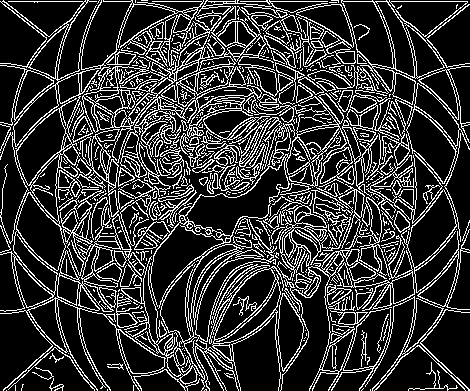

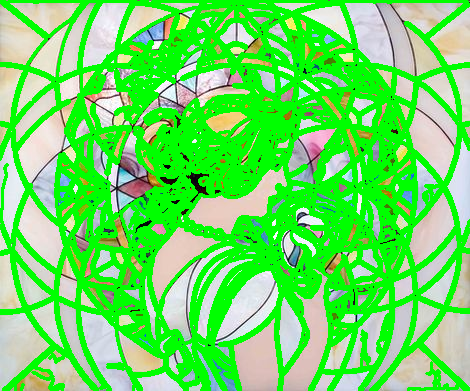

In [ ]:
## Test style image
import cv2
from google.colab.patches import cv2_imshow


test_style_images_path = '/content/drive/MyDrive/cv_project_fall_2022/data/style-images/mosaic.jpg'

image = cv2.imread(test_style_images_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(blurred, 10, 100)

# define a (3, 3) structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (1, 1))

# apply the dilation operation to the edged image
dilate = cv2.dilate(edged, kernel, iterations=1)

# find the contours in the dilated image
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
# draw the contours on a copy of the original image
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
print(len(contours), "objects were found in this image.")

cv2_imshow(dilate)
cv2_imshow(image_copy)
#cv2.waitKey(0)